<h1>Rents and social places density in Berlin, Germany.</h1>

<h3>Import initial libraries</h3>

In [6]:
import pandas as pd
import folium
import numpy as np
import json
import seaborn as sns
import re
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

%matplotlib inline

<h3>Our initial Berlin DataFrame contains the 12 Boroughs and their latitude/longitude information. I used https://github.com/m-hoerz/berlin-shapes shape file to obtain the names and Google Maps to obtain center coordinates.</h3>

In [7]:
columns = ["Borough", "Latitude","Longitude"]
rows = []
rows.append(('Mitte', 52.530880, 13.381918))
rows.append(('Friedrichshain-Kreuzberg',52.503703, 13.431762))
rows.append(('Pankow',52.592940, 13.428462))
rows.append(('Charlottenburg-Wilmersdorf',52.506477, 13.257127))
rows.append(('Spandau',52.536155, 13.201278))
rows.append(('Steglitz-Zehlendorf',52.434014, 13.191542))
rows.append(('Tempelhof-Schöneberg',52.458359, 13.387560))
rows.append(('Neukölln',52.441068, 13.441185))
rows.append(('Treptow-Köpenick',52.421899, 13.614815))
rows.append(('Marzahn-Hellersdorf',52.522653, 13.575299))
rows.append(('Lichtenberg',52.533323, 13.503729))
rows.append(('Reinickendorf',52.579943, 13.279625))
    
berlin_df = pd.DataFrame(rows, columns=columns)
berlin_df

,Borough,Latitude,Longitude
0,Mitte,52.530880,13.381918
1,Friedrichshain-Kreuzberg,52.503703,13.431762
2,Pankow,52.592940,13.428462
3,Charlottenburg-Wilmersdorf,52.506477,13.257127
4,Spandau,52.536155,13.201278
5,Steglitz-Zehlendorf,52.434014,13.191542
6,Tempelhof-Schöneberg,52.458359,13.387560
7,Neukölln,52.441068,13.441185
8,Treptow-Köpenick,52.421899,13.614815
9,Marzahn-Hellersdorf,52.522653,13.575299


<h3>Lets have a look at the Berlin map. I used Google Maps to obtain Berlin's center coordinates</h3>

In [8]:
berlin_latlon = [52.520008, 13.404954]
berlin_map = folium.Map(location=berlin_latlon, zoom_start=11)

for index,row in berlin_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Borough'],
    ).add_to(berlin_map)

berlin_map



<h3>Current (March 2019) average data on rents for each borough is obtained via https://www.wohnungsboerse.net/mietspiegel-Berlin/2825</h3>

In [9]:
berlin_rents_columns = ["Borough", "Rent"]
berlin_rents_rows = [
("Mitte", 18.25),
("Friedrichshain-Kreuzberg", 15.29),
("Pankow", 11.66),
("Charlottenburg-Wilmersdorf", 14.47),
("Spandau", 9.25),
("Steglitz-Zehlendorf", 12.29),
("Tempelhof-Schöneberg", 11.66),
("Neukölln", 13.33),
("Treptow-Köpenick", 13.28),
("Marzahn-Hellersdorf", 8.22),
("Lichtenberg", 11.40),
("Reinickendorf", 10.38)
]
berlin_rents_df = pd.DataFrame(berlin_rents_rows, columns=berlin_rents_columns)

In [98]:
#berlin_rents_df["Borough"].tolist()

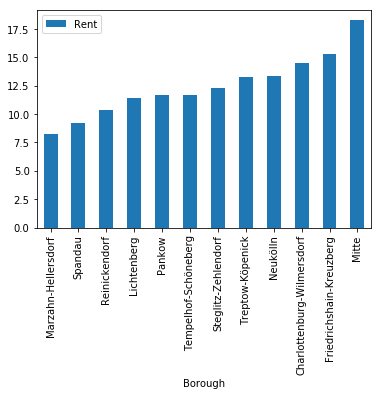

In [10]:
%matplotlib inline
berlin_rents_df.sort_values(by="Rent", ascending=True).set_index("Borough").plot.bar()

<h2>We can see, the borough Marzahn-Hellersdorf has low (8.22) while Mitte (Berlin center) has the highest (18.25) rents. Rents are per square meter and given in Euro.</h2>

<h2>Lets scrape historical data for descriptive analysis.</h2>

In [11]:
#https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [12]:
page = requests.get("https://www.wohnungsboerse.net/mietspiegel-Berlin/2825")
soup = BeautifulSoup(page.content, 'lxml')
for script in soup(["script"]): # remove all javascript code. eases parsing values later...
    script.extract()

<h3>Rent index for Berlin and rest of Germany, March 2019. Prices are per square meter and depend on the size of the flats.</h3>

In [13]:
rents_berlin_2019 = soup.find(text='Mietpreisspiegel für Mietwohnungen 2019').findNext("table")
rents_berlin_2019_columns = ["square_m", "Berlin", "Germany"]
rents_berlin_2019_rows = []

for tr in rents_berlin_2019.find("tbody").findAll("tr"):
    m2 = tr.findChildren()[0].text.strip()
    m2 = re.sub('[^0-9]','', m2)
    be = float(tr.findChildren()[1].text.strip('€').replace(",",".").strip())
    ge = float(tr.findChildren()[3].text.strip('€').replace(",",".").strip())
    rents_berlin_2019_rows.append((m2,be,ge))
    
rents_berlin_2019_df = pd.DataFrame(rents_berlin_2019_rows, columns=rents_berlin_2019_columns)
rents_berlin_2019_df

,square_m,Berlin,Germany
0,30,15.32,11.39
1,60,11.74,7.87
2,100,12.77,9.16


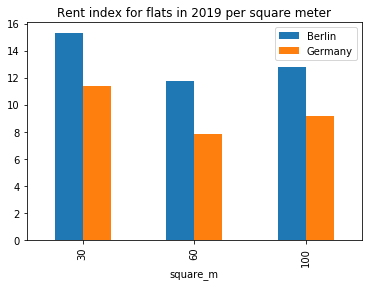

In [90]:
rents_berlin_2019_df.set_index("square_m").plot.bar(title="Rent index for flats in 2019 per square meter")

<h3>Yup, Berlin is very expensive...!</h3>

<h2>Lets check how prices evolved since 2011.</h2>

In [15]:
rents_berlin_2011_2018 = soup.find(text='Mietpreise Vergleich im Jahr 2011 - 2018').findNext("table")
rents_berlin_2011_2018_columns = ['square_m', 'Year', 'Rent']
rents_berlin_2011_2018_rows = []

current_square = 0
for tr in rents_berlin_2011_2018.find("tbody").findAll("tr"):
    if len(tr.findChildren()) == 1:
        # We found beginning of new square meter section
        current_square = re.sub('[^0-9]','', tr.findChildren()[0].text)
        continue
        
    ye = int(tr.findChildren()[0].text.strip())
    be = float(tr.findChildren()[1].text.strip('€').replace(",",".").strip())
    
    rents_berlin_2011_2018_rows.append((current_square,ye,be))
                
rents_berlin_2011_2018_df = pd.DataFrame(rents_berlin_2011_2018_rows, columns=rents_berlin_2011_2018_columns)

In [96]:
rents_berlin_2011_2018_df.head(10)

,square_m,Year,Rent
0,30,2011,8.36
1,30,2012,9.02
2,30,2013,10.08
3,30,2014,11.06
4,30,2015,11.55
5,30,2016,14.25
6,30,2017,12.04
7,30,2018,13.93
8,60,2011,6.17
9,60,2012,6.74


In [16]:
rents_berlin_2011_2018_df.tail()

,square_m,Year,Rent
19,100,2014,8.48
20,100,2015,9.55
21,100,2016,11.33
22,100,2017,11.39
23,100,2018,12.33


In [17]:
temp = rents_berlin_2019_df[["square_m", "Berlin"]].copy(deep=True)
temp.rename({"Berlin":"Rent"}, inplace=True,axis=1)
temp.insert(loc=1, column="Year", value=2019)

temp

,square_m,Year,Rent
0,30,2019,15.32
1,60,2019,11.74
2,100,2019,12.77


In [18]:
combined_data = pd.concat([rents_berlin_2011_2018_df,temp]).reset_index()

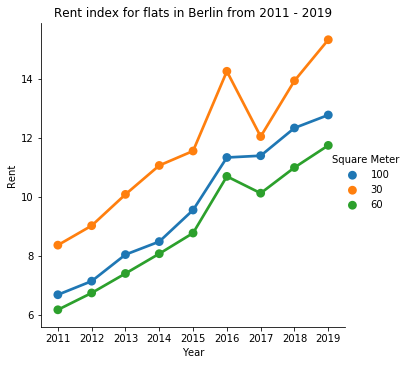

In [94]:
rents_berlin_2011_2018_plot = sns.catplot(x="Year", y="Rent", hue="square_m", kind="point", data=combined_data,legend_out=True)
rents_berlin_2011_2018_plot._legend.set_title("Square Meter")


plt.title('Rent index for flats in Berlin from 2011 - 2019',size=12)
plt.show()

<h3>Since 2011 rents almost doubled! People who want to move to Berlin should take this into account. The prices will keep rising. Either now or never ;-).</h3>

<h1>Foursquare - Get venues for each borough</h1>

In [48]:
CLIENT_ID = '###' # your Foursquare ID
CLIENT_SECRET = '###' # your Foursquare Secret
VERSION = '20190310' # Foursquare API version

<h2>Function to get nearby venues taken from the lab</h2>

In [21]:
import requests
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h2>We want 100 nearby venues in all boroughs within a range of 1000 meters.</h2>

In [22]:
berlin_venues = getNearbyVenues(names=berlin_df['Borough'],
                                   latitudes=berlin_df['Latitude'],
                                   longitudes=berlin_df['Longitude']
                                  )

Mitte
Friedrichshain-Kreuzberg
Pankow
Charlottenburg-Wilmersdorf
Spandau
Steglitz-Zehlendorf
Tempelhof-Schöneberg
Neukölln
Treptow-Köpenick
Marzahn-Hellersdorf
Lichtenberg
Reinickendorf


In [23]:
print("Shape is:",berlin_venues.shape)
berlin_venues.head()

Shape is: (458, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.53088,13.381918,Museum für Naturkunde,52.530271,13.379281,Science Museum
1,Mitte,52.53088,13.381918,Hotel i31,52.531107,13.384270,Hotel
2,Mitte,52.53088,13.381918,Brasserie La Bonne Franquette,52.531102,13.382489,Brasserie
3,Mitte,52.53088,13.381918,Titanic Chaussee Berlin,52.532215,13.381012,Hotel
4,Mitte,52.53088,13.381918,19grams,52.533037,13.380054,Coffee Shop


<h2>Lets stick with the term boroughs instea of neighborhood.</h2>

In [24]:
berlin_venues.rename(columns={"Neighborhood": "Borough", "Neighborhood Latitude": "Borough Latitude", "Neighborhood Longitude" : "Borough Longitude"}, inplace=True)

In [25]:
# Just for confirmation
print(berlin_venues.shape)
berlin_venues.head()

(458, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.53088,13.381918,Museum für Naturkunde,52.530271,13.379281,Science Museum
1,Mitte,52.53088,13.381918,Hotel i31,52.531107,13.384270,Hotel
2,Mitte,52.53088,13.381918,Brasserie La Bonne Franquette,52.531102,13.382489,Brasserie
3,Mitte,52.53088,13.381918,Titanic Chaussee Berlin,52.532215,13.381012,Hotel
4,Mitte,52.53088,13.381918,19grams,52.533037,13.380054,Coffee Shop


<h2>Lets see the amount of values in each Borough</h2>

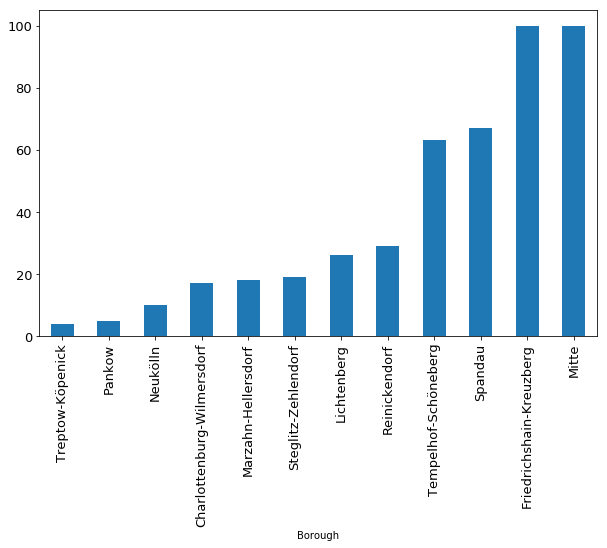

In [106]:
berlin_venues.groupby('Borough').size().sort_values().plot(kind='bar',figsize=(10,6), fontsize=13)

In [27]:
print('There are {} uniques categories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 166 uniques categories.


<h2>We use one hot encoding for venue categories</h2>

In [28]:
# one hot encoding
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Borough'] = berlin_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot.head()

,Borough,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,...,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
berlin_onehot['Borough'].unique()

array(['Mitte', 'Friedrichshain-Kreuzberg', 'Pankow',
       'Charlottenburg-Wilmersdorf', 'Spandau', 'Steglitz-Zehlendorf',
       'Tempelhof-Schöneberg', 'Neukölln', 'Treptow-Köpenick',
       'Marzahn-Hellersdorf', 'Lichtenberg', 'Reinickendorf'],
      dtype=object)

<h2>We calculate the mean presence for each venue type which is used for clustering</h2>

In [30]:
berlin_grouped = berlin_onehot.groupby('Borough').mean().reset_index()
berlin_grouped

,Borough,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,...,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Charlottenburg-Wilmersdorf,0.00,0.000000,0.00,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
1,Friedrichshain-Kreuzberg,0.01,0.000000,0.02,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,...,0.000000,0.020000,0.02,0.00,0.030000,0.00,0.000000,0.01,0.01,0.01
2,Lichtenberg,0.00,0.000000,0.00,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,...,0.192308,0.000000,0.00,0.00,0.038462,0.00,0.000000,0.00,0.00,0.00
3,Marzahn-Hellersdorf,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
4,Mitte,0.00,0.000000,0.03,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.010000,0.00,0.02,0.030000,0.01,0.000000,0.01,0.00,0.00
5,Neukölln,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
6,Pankow,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
7,Reinickendorf,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.034483,0.00,0.00,0.00
8,Spandau,0.00,0.014925,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.029851,0.00,0.00,0.014925,0.00,0.000000,0.00,0.00,0.00
9,Steglitz-Zehlendorf,0.00,0.000000,0.00,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00


<h2>Here are the top 5 venues in each Borough / Hood</h2>

In [31]:
num_top_venues = 5

for hood in berlin_grouped['Borough']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Charlottenburg-Wilmersdorf----
                venue  freq
0  Italian Restaurant  0.12
1                Café  0.12
2     Thai Restaurant  0.06
3         Pizza Place  0.06
4  Chinese Restaurant  0.06


----Friedrichshain-Kreuzberg----
                venue  freq
0                Café  0.07
1   German Restaurant  0.07
2                 Bar  0.06
3         Coffee Shop  0.05
4  Italian Restaurant  0.04


----Lichtenberg----
                    venue  freq
0            Tram Station  0.19
1  Furniture / Home Store  0.08
2                   Hotel  0.08
3                  Bakery  0.04
4             Supermarket  0.04


----Marzahn-Hellersdorf----
                venue  freq
0         Supermarket  0.39
1            Bus Stop  0.17
2               Trail  0.11
3  Miscellaneous Shop  0.06
4       Shopping Mall  0.06


----Mitte----
                venue  freq
0         Coffee Shop  0.07
1               Hotel  0.06
2  Italian Restaurant  0.03
3          Restaurant  0.03
4         Art Gallery  0.0

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<h2>Now, lets obtain the top 10 venues for each Borough and create a DataFrame</h2>

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = berlin_grouped['Borough']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,Café,Italian Restaurant,Hotel,Thai Restaurant,Chinese Restaurant,Comedy Club,Organic Grocery,Building,Mountain,Stadium
1,Friedrichshain-Kreuzberg,Café,German Restaurant,Bar,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Bakery,Cocktail Bar,Ice Cream Shop,Nightclub
2,Lichtenberg,Tram Station,Hotel,Furniture / Home Store,Motorcycle Shop,Drugstore,Music Venue,Memorial Site,Cafeteria,Supermarket,German Restaurant
3,Marzahn-Hellersdorf,Supermarket,Bus Stop,Trail,Gym,Miscellaneous Shop,Drugstore,Lake,Auto Garage,Shopping Mall,Doner Restaurant
4,Mitte,Coffee Shop,Hotel,Restaurant,Café,Falafel Restaurant,Italian Restaurant,Japanese Restaurant,Bakery,Art Gallery,Vietnamese Restaurant


<h2>In order to create good clusters, we need to determine k, the amount of clusters. I will use the elbow method to obtain optimal k</h2>

In [34]:
berlin_grouped.drop('Borough', 1)

,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,...,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,0.00,0.000000,0.00,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
1,0.01,0.000000,0.02,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.020000,0.02,0.00,0.030000,0.00,0.000000,0.01,0.01,0.01
2,0.00,0.000000,0.00,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,...,0.192308,0.000000,0.00,0.00,0.038462,0.00,0.000000,0.00,0.00,0.00
3,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
4,0.00,0.000000,0.03,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010000,0.00,0.02,0.030000,0.01,0.000000,0.01,0.00,0.00
5,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
6,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00
7,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.034483,0.00,0.00,0.00
8,0.00,0.014925,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,...,0.000000,0.029851,0.00,0.00,0.014925,0.00,0.000000,0.00,0.00,0.00
9,0.00,0.000000,0.00,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00


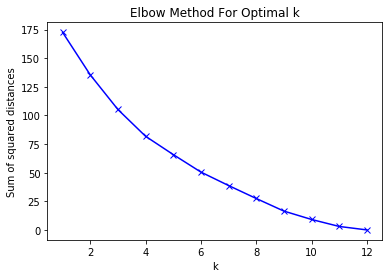

In [35]:
berlin_grouped_clustering = berlin_grouped.drop('Borough', 1)

X = MinMaxScaler().fit(berlin_grouped_clustering).transform(berlin_grouped_clustering)

sum_of_squared_distances = []
K = range(1,13)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<h2>The optimal k is hard to see, its either 4 or 5. I will stick with 4 since there are only 12 boroughs.</h2>

In [36]:
kclusters = 4

berlin_grouped_clustering = berlin_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 2, 3, 0, 2, 3, 3, 3], dtype=int32)

<h2>We merge cluster labels and venues</h2>

In [57]:
#neighborhoods_venues_sorted.drop("Cluster Labels", inplace=True,axis=1)

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

berlin_merged = berlin_df

berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

berlin_merged.head() # check the last columns!

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mitte,52.530880,13.381918,3,Coffee Shop,Hotel,Restaurant,Café,Falafel Restaurant,Italian Restaurant,Japanese Restaurant,Bakery,Art Gallery,Vietnamese Restaurant
1,Friedrichshain-Kreuzberg,52.503703,13.431762,3,Café,German Restaurant,Bar,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Bakery,Cocktail Bar,Ice Cream Shop,Nightclub
2,Pankow,52.592940,13.428462,2,Supermarket,Hotel,Gas Station,Bus Stop,Yoga Studio,Doner Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Electronics Store
3,Charlottenburg-Wilmersdorf,52.506477,13.257127,3,Café,Italian Restaurant,Hotel,Thai Restaurant,Chinese Restaurant,Comedy Club,Organic Grocery,Building,Mountain,Stadium
4,Spandau,52.536155,13.201278,3,Supermarket,Drugstore,Ice Cream Shop,Mobile Phone Shop,Italian Restaurant,Pizza Place,Park,Clothing Store,Bakery,Restaurant


In [38]:
berlin_merged['Cluster Labels'].values

array([3, 3, 2, 3, 3, 3, 3, 0, 1, 2, 3, 3], dtype=int32)

<h2>Lets print top 5 venues for each cluster so we can give names and descriptions to clusters</h2>

In [131]:
for i in range(kclusters):
    print("Cluster",i, ', '.join(berlin_merged[berlin_merged["Cluster Labels"] == i].iloc[:,4:9].values.tolist()[0]))

Cluster 0 Bus Stop, Department Store, History Museum, Historic Site, Sculpture Garden
Cluster 1 Hotel, Forest, Scenic Lookout, Mountain, Yoga Studio
Cluster 2 Supermarket, Hotel, Gas Station, Bus Stop, Yoga Studio
Cluster 3 Coffee Shop, Hotel, Restaurant, Café, Falafel Restaurant


<h3>Cluster 2 is hard to figure out. Lets see more venues...</h3>

In [40]:
print("Cluster",2, berlin_merged[berlin_merged["Cluster Labels"] == 2].iloc[:,4:].values.tolist()[0])


Cluster 2 ['Supermarket', 'Hotel', 'Gas Station', 'Bus Stop', 'Yoga Studio', 'Doner Restaurant', 'Fast Food Restaurant', 'Falafel Restaurant', 'Event Space', 'Electronics Store']


In [41]:
cluster_desc = {}
cluster_desc[0] = "History & Museum"
cluster_desc[1] = "Nature & Relax"
cluster_desc[2] = "Supermarket and Food"
cluster_desc[3] = "Café & Restaurant"

<h2>Now we want to create a map with clustered buroughs.</h2>

In [42]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=berlin_latlon, zoom_start=11)

colors = [
    'red',
    'blue',
    'green',
    'orange',
    #'purple'
]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Borough'], berlin_merged['Cluster Labels']):
    txt = str(poi) + ' - Cluster ' + str(cluster) + ' - ' + str(cluster_desc[cluster])
    label = folium.Popup(txt, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    print(txt)

Mitte - Cluster 3 - Café & Restaurant
Friedrichshain-Kreuzberg - Cluster 3 - Café & Restaurant
Pankow - Cluster 2 - Supermarket and Food
Charlottenburg-Wilmersdorf - Cluster 3 - Café & Restaurant
Spandau - Cluster 3 - Café & Restaurant
Steglitz-Zehlendorf - Cluster 3 - Café & Restaurant
Tempelhof-Schöneberg - Cluster 3 - Café & Restaurant
Neukölln - Cluster 0 - History & Museum
Treptow-Köpenick - Cluster 1 - Nature & Relax
Marzahn-Hellersdorf - Cluster 2 - Supermarket and Food
Lichtenberg - Cluster 3 - Café & Restaurant
Reinickendorf - Cluster 3 - Café & Restaurant


<h2>Display map with clustered Boroughs</h2>

In [43]:
map_clusters

<h2>Finally, lets add rent data and colorize Boroughs according to the average rent</h2>

In [44]:
!wget https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson
print("Shape File downloaded")

--2019-03-11 12:24:28--  https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.124.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.124.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 459720 (449K) [text/plain]
Saving to: ‘berliner-bezirke.geojson.1’

berliner-bezirke.ge 100%[=====================>] 448.95K  --.-KB/s   in 0.01s  

2019-03-11 12:24:28 (35.0 MB/s) - ‘berliner-bezirke.geojson.1’ saved [459720/459720]

Shape File downloaded


In [45]:
berlin_geo = r'berliner-bezirke.geojson'
map_clusters.choropleth(
    geo_data=berlin_geo,
    key_on='feature.properties.spatial_alias',
    data=berlin_rents_df,
    columns=["Borough", "Rent"],
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average rents in Berlin in Euro per square meter'
)

<h2>The updated map</h2>

In [46]:
map_clusters

<h2>Looks pretty cool! However, lets do it again. This time, we colorize boroughs first and then place the markers on top. Otherwise they are not clickable...</h2>

In [102]:
# create map
map_clusters = folium.Map(location=berlin_latlon, zoom_start=11)

berlin_geo = r'berliner-bezirke.geojson'
map_clusters.choropleth(
    geo_data=berlin_geo,
    key_on='feature.properties.spatial_alias',
    data=berlin_rents_df,
    columns=["Borough", "Rent"],
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rents in Berlin in Euro per square meter'
)

colors = [
    'red',
    'blue',
    'green',
    'orange',
    #'purple'
]

for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Borough'], berlin_merged['Cluster Labels']):
    txt = str(poi) + ' - Cluster ' + str(cluster) + ' - ' + str(cluster_desc[cluster])
    label = folium.Popup(txt, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

<h2>Some very simple price predictions. Used for descriptive analysis.</h2>

Yes, I use all points for training. In fact, I just want have a simple regression line...

>> 30 2020 15.874444444444634
>> 30 2021 16.70244444444461
>> 30 2022 17.530444444444583
>> 30 2023 18.358444444444558
>> 30 2024 19.186444444444533
>> 60 2020 12.556388888888705
>> 60 2021 13.27455555555548
>> 60 2022 13.992722222222028
>> 60 2023 14.710888888888803
>> 60 2024 15.429055555555351
>> 100 2020 13.868888888888705
>> 100 2021 14.69355555555535
>> 100 2022 15.518222222221993
>> 100 2023 16.342888888888865
>> 100 2024 17.16755555555551


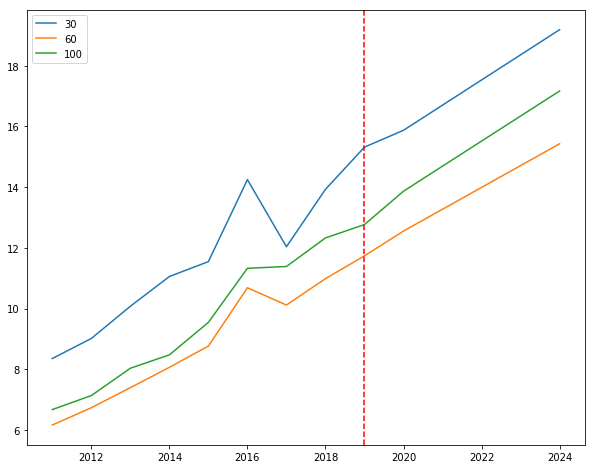

In [150]:
from sklearn import datasets, linear_model

plt.rcParams["figure.figsize"] = (10,8)

for sm in combined_data.square_m.unique():
    prices_sm = np.array(combined_data[combined_data["square_m"]==sm][["Year","Rent"]])
    years = np.array([x[0] for x in prices_sm]).reshape(-1, 1)
    rents = np.array([x[1] for x in prices_sm]).reshape(-1, 1)
    
    regr = linear_model.LinearRegression()
    regr.fit(years, rents)
    
    pred_years = np.array([2020, 2021, 2022, 2023, 2024]).reshape(-1, 1)
    pred_rents = regr.predict(pred_years)

    plt.plot(np.concatenate((years,pred_years),axis=0), np.concatenate((rents,pred_rents),axis=0), label=sm)
    #plt.plot(np.concatenate((years,pred_years),axis=0), regr.predict(np.concatenate((years,pred_years),axis=0)), color='blue', linewidth=1,alpha=0.7)
    for y, r in zip(pred_years, pred_rents):
        print (">>",sm, y[0], r[0])


plt.axvline(x=2019, color='r', linestyle='--')
plt.legend(loc='best')
plt.show()